In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+--------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|    simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|                date|            time|temperature_2m (°C)|precipitation (mm)|rain

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------+---------+---------+--------+
|    simp_date| latitude|longitude| borough|
+-------------+---------+---------+--------+
|2021-09-11 09|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08| 40.86816|-73.83148|   BRONX|
|2021-12-14 21| 40.67172| -73.8971|BROOKLYN|
+-------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('month', split(df['simp_date'], '-').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+-----+
|latitude          |longitude |borough      |month|
+------------------+----------+-------------+-----+
|40.667202         |-73.8665  |BROOKLYN     |09   |
|40.86816          |-73.83148 |BRONX        |12   |
|40.67172          |-73.8971  |BROOKLYN     |12   |
|40.75144          |-73.97397 |MANHATTAN    |12   |
|40.675883999999996|-73.75577 |QUEENS       |12   |
|40.66684          |-73.78941 |QUEENS       |12   |
|40.68158          |-73.97463 |BROOKLYN     |12   |
|40.65068          |-73.95881 |BROOKLYN     |12   |
|40.87262          |-73.904686|BRONX        |12   |
|40.748917         |-73.993546|MANHATTAN    |12   |
|40.75373          |-73.88505 |QUEENS       |12   |
|40.63165          |-74.08762 |STATEN ISLAND|12   |
|40.623104         |-73.95809 |BROOKLYN     |12   |
|40.66576          |-73.9845  |BROOKLYN     |12   |
|40.687534         |-73.9775  |BROOKLYN     |12   |
|40.710957         |-73.951126|BROOKLYN     |12   |
|40.81813   

### STATEN ISLAND_spring

In [5]:
spring = df1.rdd.filter(lambda x: x[3]=='03' or x[3]=='04' or x[3]=='05')
spring = spring.filter(lambda x: x[2]=="STATEN ISLAND")
spring = spring.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
spring = spring.map(lambda x: [x[0], x[1]])

loc_spring = spring.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_spring)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.637833| -74.08193|[40.637833,-74.08...|
|40.596733| -74.07045|[40.596733,-74.07...|
|40.609768| -74.06969|[40.609768,-74.06...|
|40.526894| -74.16728|[40.526894,-74.16...|
|40.542908| -74.15579|[40.542908,-74.15...|
| 40.57365| -74.11252|[40.57365,-74.11252]|
| 40.54048|-74.153404|[40.54048,-74.153...|
|40.565254|  -74.1301|[40.565254,-74.1301]|
|40.634415| -74.08535|[40.634415,-74.08...|
| 40.62046| -74.07641|[40.62046,-74.07641]|
| 40.61378| -74.07225|[40.61378,-74.07225]|
|40.573204| -74.09711|[40.573204,-74.09...|
|40.575832| -74.12409|[40.575832,-74.12...|
|40.540188|   -74.149| [40.540188,-74.149]|
| 40.63115|-74.076454|[40.63115,-74.076...|
|  40.6354|-74.106674|[40.6354,-74.106674]|
|40.540833|-74.159386|[40.540833,-74.15...|
|40.609436|  -74.0694|[40.609436,-74.0694]|
| 40.60109| -74.09284|[40.60109,-74.09284]|
|40.597706|-74.092575|[40.597706

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.637833| -74.08193|[40.637833,-74.08...|         3|
|40.596733| -74.07045|[40.596733,-74.07...|         1|
|40.609768| -74.06969|[40.609768,-74.06...|         1|
|40.526894| -74.16728|[40.526894,-74.16...|         2|
|40.542908| -74.15579|[40.542908,-74.15...|         2|
| 40.57365| -74.11252|[40.57365,-74.11252]|         4|
| 40.54048|-74.153404|[40.54048,-74.153...|         2|
|40.565254|  -74.1301|[40.565254,-74.1301]|        19|
|40.634415| -74.08535|[40.634415,-74.08...|         3|
| 40.62046| -74.07641|[40.62046,-74.07641]|        10|
| 40.61378| -74.07225|[40.61378,-74.07225]|         1|
|40.573204| -74.09711|[40.573204,-74.09...|         7|
|40.575832| -74.12409|[40.575832,-74.12...|         4|
|40.540188|   -74.149| [40.540188,-74.149]|         2|
| 40.63115|-74.076454|[40.63115,-74.076...|        10|
|  40.6354

In [7]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.63278524 -74.11966378]
[ 40.60487111 -74.06835917]
[ 40.54220944 -74.15699207]
[ 40.64005829 -74.08385765]
[ 40.57055134 -74.11466507]
[ 40.52381338 -74.20829811]
[ 40.51686908 -74.23797769]
[ 40.58148815 -74.10147092]
[ 40.8241795  -73.91841125]
[ 40.721222 -73.977781]
[ 40.62406442 -74.07886726]
[ 40.61086059 -74.08702045]
[ 40.55856455 -74.16808489]
[ 40.62107207 -74.10279934]
[ 40.59241836 -74.08777382]
[ 40.6877548 -73.881817 ]
[ 40.54227942 -74.18836014]
[ 40.60995191 -74.1208885 ]
[ 40.5443631  -74.21658095]
[ 40.56137259 -74.13716068]


Text(0.5,1,'STATEN ISLAND_spring')

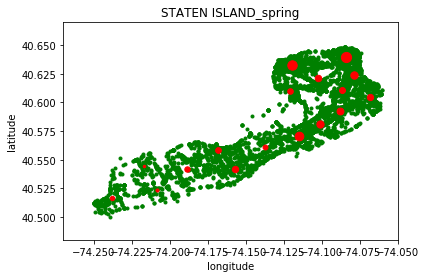

In [8]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=3)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/60)
            idx+=1
            
plt.xlim([-74.27, -74.05])
plt.ylim([40.48, 40.67])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("STATEN ISLAND_spring")

### STATEN ISLAND_summer

In [9]:
summer = df1.rdd.filter(lambda x: x[3]=='06' or x[3]=='07' or x[3]=='08')
summer = summer.filter(lambda x: x[2]=="STATEN ISLAND")
summer = summer.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
summer = summer.map(lambda x: [x[0], x[1]])

loc_summer = summer.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_summer)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
| 40.60203| -74.09572|[40.60203,-74.09572]|
| 40.60172| -74.09143|[40.60172,-74.09143]|
|40.593918| -74.07091|[40.593918,-74.07...|
| 40.63029| -74.08891|[40.63029,-74.08891]|
|  40.6228| -74.08526| [40.6228,-74.08526]|
| 40.60113| -74.09704|[40.60113,-74.09704]|
| 40.57902| -74.10661|[40.57902,-74.10661]|
| 40.55514|-74.130005|[40.55514,-74.130...|
| 40.63431| -74.12008|[40.63431,-74.12008]|
|40.557106| -74.17385|[40.557106,-74.17...|
|40.591034| -74.10127|[40.591034,-74.10...|
|40.541874| -74.15155|[40.541874,-74.15...|
|40.575813| -74.11979|[40.575813,-74.11...|
|40.554417| -74.13047|[40.554417,-74.13...|
| 40.63781| -74.08729|[40.63781,-74.08729]|
|40.575363| -74.10485|[40.575363,-74.10...|
|40.577366| -74.11145|[40.577366,-74.11...|
| 40.54208|-74.157234|[40.54208,-74.157...|
|40.576504|  -74.1037|[40.576504,-74.1037]|
| 40.55234|-74.133194|[40.55234,

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 40.60203| -74.09572|[40.60203,-74.09572]|        14|
| 40.60172| -74.09143|[40.60172,-74.09143]|        14|
|40.593918| -74.07091|[40.593918,-74.07...|         6|
| 40.63029| -74.08891|[40.63029,-74.08891]|        16|
|  40.6228| -74.08526| [40.6228,-74.08526]|        16|
| 40.60113| -74.09704|[40.60113,-74.09704]|        14|
| 40.57902| -74.10661|[40.57902,-74.10661]|        11|
| 40.55514|-74.130005|[40.55514,-74.130...|         8|
| 40.63431| -74.12008|[40.63431,-74.12008]|         5|
|40.557106| -74.17385|[40.557106,-74.17...|        19|
|40.591034| -74.10127|[40.591034,-74.10...|         2|
|40.541874| -74.15155|[40.541874,-74.15...|         0|
|40.575813| -74.11979|[40.575813,-74.11...|        11|
|40.554417| -74.13047|[40.554417,-74.13...|         8|
| 40.63781| -74.08729|[40.63781,-74.08729]|         1|
|40.575363

In [11]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.54839027 -74.14684282]
[ 40.6394942  -74.08202155]
[ 40.58607231 -74.09335101]
[ 40.60017191 -74.11776212]
[ 40.51694269 -74.23810846]
[ 40.63204597 -74.12096686]
[ 40.60364758 -74.06831251]
[ 40.7248514 -73.968884 ]
[ 40.56746336 -74.13196486]
[ 40.54047664 -74.16514146]
[ 40.55196111 -74.1897043 ]
[ 40.57248326 -74.10993371]
[ 40.6358821  -74.10430488]
[ 40.53928684 -74.21538649]
[ 40.60634269 -74.08575784]
[ 40.61528729 -74.10215356]
[ 40.62338629 -74.07990703]
[ 40.61412445 -74.12207585]
[ 40.52773477 -74.19662075]
[ 40.55889167 -74.16864032]


Text(0.5,1,'STATEN ISLAND_summer')

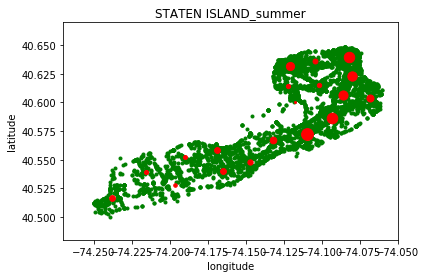

In [12]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=3)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/60)
            idx+=1
            
plt.xlim([-74.27, -74.05])
plt.ylim([40.48, 40.67])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("STATEN ISLAND_summer")

### STATEN ISLAND_fall

In [13]:
fall = df1.rdd.filter(lambda x: x[3]=='09' or x[3]=='10' or x[3]=='11')
fall = fall.filter(lambda x: x[2]=="STATEN ISLAND")
fall = fall.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
fall = fall.map(lambda x: [x[0], x[1]])

loc_fall = fall.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_fall)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.629475|  -74.1123|[40.629475,-74.1123]|
| 40.56692|-74.116234|[40.56692,-74.116...|
|40.591778| -74.12734|[40.591778,-74.12...|
|40.634007| -74.07516|[40.634007,-74.07...|
|40.553192|-74.164345|[40.553192,-74.16...|
|40.590313| -74.09794|[40.590313,-74.09...|
| 40.62782| -74.12126|[40.62782,-74.12126]|
|40.635998| -74.11747|[40.635998,-74.11...|
| 40.59702| -74.09339|[40.59702,-74.09339]|
|40.569706|-74.144394|[40.569706,-74.14...|
| 40.58524|-74.093414|[40.58524,-74.093...|
|40.543495| -74.14747|[40.543495,-74.14...|
| 40.56029|-74.165924|[40.56029,-74.165...|
| 40.63157|  -74.0775| [40.63157,-74.0775]|
|40.551266| -74.14962|[40.551266,-74.14...|
|40.595104| -74.07541|[40.595104,-74.07...|
|40.639984| -74.08663|[40.639984,-74.08...|
|40.642242|  -74.0752|[40.642242,-74.0752]|
| 40.61659|   -74.068|  [40.61659,-74.068]|
| 40.61751| -74.07305|[40.61751,

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.629475|  -74.1123|[40.629475,-74.1123]|         3|
| 40.56692|-74.116234|[40.56692,-74.116...|         5|
|40.591778| -74.12734|[40.591778,-74.12...|        15|
|40.634007| -74.07516|[40.634007,-74.07...|         2|
|40.553192|-74.164345|[40.553192,-74.16...|         9|
|40.590313| -74.09794|[40.590313,-74.09...|        17|
| 40.62782| -74.12126|[40.62782,-74.12126]|         3|
|40.635998| -74.11747|[40.635998,-74.11...|         3|
| 40.59702| -74.09339|[40.59702,-74.09339]|         7|
|40.569706|-74.144394|[40.569706,-74.14...|        13|
| 40.58524|-74.093414|[40.58524,-74.093...|        12|
|40.543495| -74.14747|[40.543495,-74.14...|         8|
| 40.56029|-74.165924|[40.56029,-74.165...|         9|
| 40.63157|  -74.0775| [40.63157,-74.0775]|        16|
|40.551266| -74.14962|[40.551266,-74.14...|         8|
|40.595104

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.60422712 -74.06841185]
[ 40.52757339 -74.19739547]
[ 40.63934828 -74.0836448 ]
[ 40.63307447 -74.11803114]
[ 40.52346852 -74.23223772]
[ 40.5702649  -74.11255988]
[ 40.50964514 -74.24279787]
[ 40.59566718 -74.08676874]
[ 40.54305662 -74.15517619]
[ 40.5586691  -74.16559019]
[ 40.6180884  -74.10215297]
[ 40.61099086 -74.08664624]
[ 40.57984828 -74.09558545]
[ 40.56522694 -74.13491681]
[ 40.5503113 -74.1866354]
[ 40.61109554 -74.12163845]
[ 40.6241283  -74.07860031]
[ 40.58978515 -74.10391353]
[ 40.75137833 -73.92851117]
[ 40.54548933 -74.21578887]


Text(0.5,1,'STATEN ISLAND_fall')

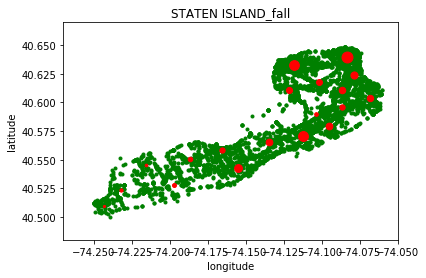

In [16]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=3)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/60)
            idx+=1
            
plt.xlim([-74.27, -74.05])
plt.ylim([40.48, 40.67])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("STATEN ISLAND_fall")

### STATEN ISLAND_winter

In [17]:
winter = df1.rdd.filter(lambda x: x[3]=='12' or x[3]=='01' or x[3]=='02')
winter = winter.filter(lambda x: x[2]=="STATEN ISLAND")
winter = winter.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
winter = winter.map(lambda x: [x[0], x[1]])

loc_winter = winter.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_winter)
new_df.show()

+------------------+----------+--------------------+
|          latitude| longitude|            features|
+------------------+----------+--------------------+
|          40.63165| -74.08762|[40.63165,-74.08762]|
|          40.62121| -74.12385|[40.62121,-74.12385]|
|          40.57089| -74.14791|[40.57089,-74.14791]|
|         40.616684| -74.08688|[40.616684,-74.08...|
|         40.623524|-74.083015|[40.623524,-74.08...|
|         40.560104|-74.124405|[40.560104,-74.12...|
|         40.593987| -74.07684|[40.593987,-74.07...|
|         40.547924|-74.166954|[40.547924,-74.16...|
|         40.579174| -74.11483|[40.579174,-74.11...|
|          40.55349| -74.13178|[40.55349,-74.13178]|
|40.643496999999996| -74.07418|[40.6434969999999...|
|         40.608833| -74.12118|[40.608833,-74.12...|
|         40.546955| -74.18129|[40.546955,-74.18...|
|         40.546707| -74.19913|[40.546707,-74.19...|
|          40.56146| -74.11227|[40.56146,-74.11227]|
|         40.580208| -74.09975|[40.580208,-74.

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------------------+----------+
|          latitude| longitude|            features|prediction|
+------------------+----------+--------------------+----------+
|          40.63165| -74.08762|[40.63165,-74.08762]|         1|
|          40.62121| -74.12385|[40.62121,-74.12385]|        19|
|          40.57089| -74.14791|[40.57089,-74.14791]|        14|
|         40.616684| -74.08688|[40.616684,-74.08...|         9|
|         40.623524|-74.083015|[40.623524,-74.08...|        15|
|         40.560104|-74.124405|[40.560104,-74.12...|        14|
|         40.593987| -74.07684|[40.593987,-74.07...|        18|
|         40.547924|-74.166954|[40.547924,-74.16...|        11|
|         40.579174| -74.11483|[40.579174,-74.11...|        12|
|          40.55349| -74.13178|[40.55349,-74.13178]|         0|
|40.643496999999996| -74.07418|[40.6434969999999...|         1|
|         40.608833| -74.12118|[40.608833,-74.12...|        19|
|         40.546955| -74.18129|[40.54695

In [19]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.55114255 -74.14575781]
[ 40.63913975 -74.08127839]
[ 40.908127 -73.896576]
[ 40.57940829 -74.10247175]
[ 40.51745547 -74.23771072]
[ 40.63198051 -74.12040098]
[ 40.54337313 -74.18923541]
[ 40.63482819 -74.09916461]
[ 40.7309915 -73.818397 ]
[ 40.60733696 -74.08627168]
[ 40.559067   -74.16985169]
[ 40.54000046 -74.16227505]
[ 40.56956982 -74.11381486]
[ 40.61515565 -74.10236074]
[ 40.57005264 -74.13360239]
[ 40.62224729 -74.07923638]
[ 40.5345108 -74.2113966]
[ 40.59019897 -74.09063147]
[ 40.60258248 -74.06829251]
[ 40.61038495 -74.12092732]


Text(0.5,1,'STATEN ISLAND_winter')

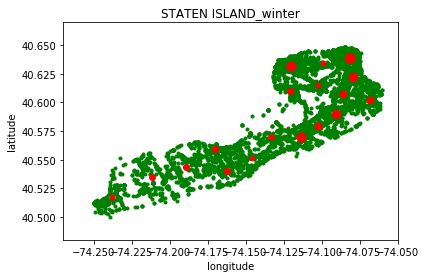

In [20]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=3)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]<-74.05 and i[1]>-74.25:
        if i[0]>40.50 and i[0]<40.65:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/60)
            idx+=1
            
plt.xlim([-74.27, -74.05])
plt.ylim([40.48, 40.67])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("STATEN ISLAND_winter")